same example as dogs v/s cats but now implementing data augmentation

In [2]:
import os
import pickle 

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
from io import BytesIO

from ipywidgets import widgets 

In [3]:
TRAIN_DIR = 'train'
VAL_DIR   = 'test'

train_dogs_dir   = os.path.join(TRAIN_DIR, 'dogs')
train_cats_dir   = os.path.join(TRAIN_DIR, 'cats')
validate_dogs_dir = os.path.join(VAL_DIR, 'dogs')
validate_cats_dir = os.path.join(VAL_DIR, 'cats')

In [4]:
print(f"total training dogs images: {len(os.listdir(train_dogs_dir))}")
print(f"total training cats images: {len(os.listdir(train_cats_dir))}")
print(f"total validation dogs images: {len(os.listdir(validate_dogs_dir))}")
print(f"total validation cats images: {len(os.listdir(validate_cats_dir))}")

total training dogs images: 10000
total training cats images: 10000
total validation dogs images: 2500
total validation cats images: 2500


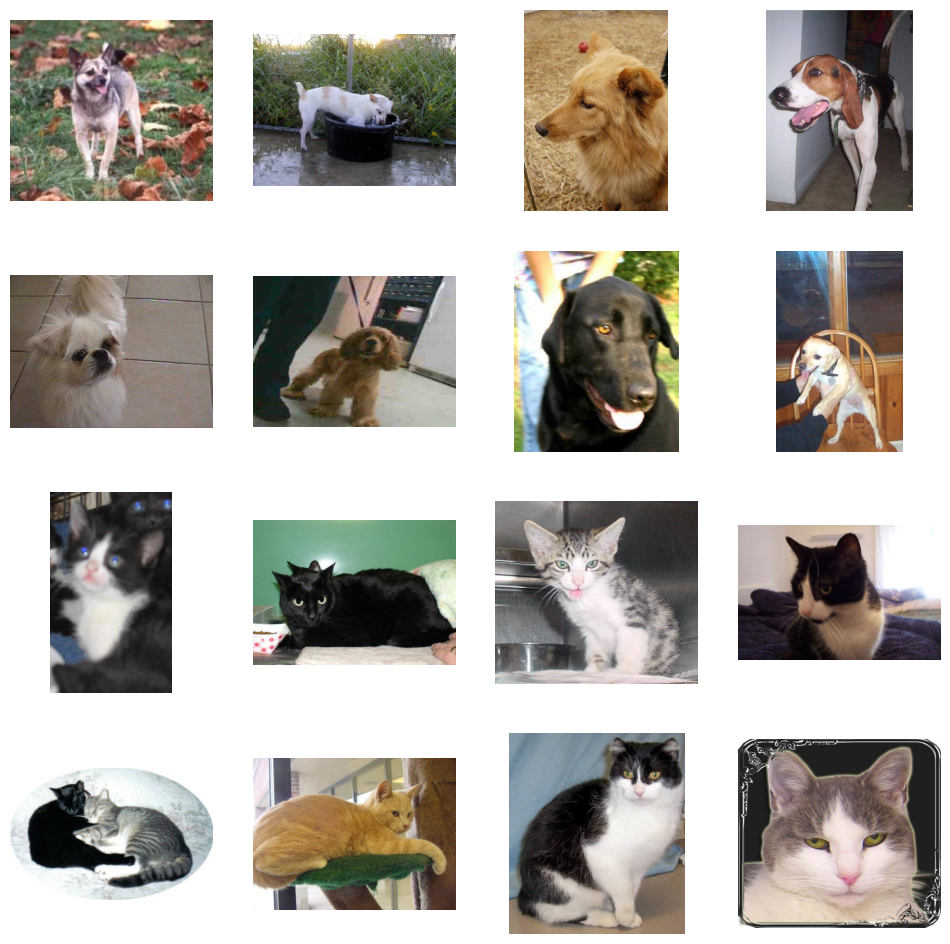

In [5]:
train_dogs_names = os.listdir(train_dogs_dir)
train_cats_names = os.listdir(train_cats_dir)

n_rows = 4
n_cols = 4

fig = plt.gcf()
fig.set_size_inches(n_cols * 3, n_rows * 3)

next_dogs_pix = [os.path.join(train_dogs_dir, fname)
                for fname in random.sample(train_dogs_names, k=8)]
next_cats_pix = [os.path.join(train_cats_dir, fname)
                for fname in random.sample(train_cats_names, k=8)]

for i, img_path in enumerate(next_dogs_pix + next_cats_pix):
    sp = plt.subplot(n_rows, n_cols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

time to create the actual model

In [6]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(150,150,3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32,(3,3),activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3),activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128,(3,3),activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128,(3,3),activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512,activation=tf.nn.relu),
        tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    ])
    
    return model  

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size = (150,150),
    batch_size = 20,
    label_mode = 'binary'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size = (150,150),
    batch_size = 20,
    label_mode = 'binary'
)

Found 20000 files belonging to 2 classes.


I0000 00:00:1753074536.141800    5550 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5477 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 5000 files belonging to 2 classes.


In [8]:
SHUFFLE_BATCH_SIZE = 1000
PREFETCH_BATCH_SIZE = tf.data.AUTOTUNE

final_training_dataset = (train_dataset
                          .cache()
                          .shuffle(SHUFFLE_BATCH_SIZE)
                          .prefetch(PREFETCH_BATCH_SIZE)
                          )

final_validation_dataset = (validation_dataset
                          .cache()
                          .shuffle(SHUFFLE_BATCH_SIZE)
                          .prefetch(PREFETCH_BATCH_SIZE)
                          )

In [9]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('loss') <= 0.2 and logs.get('val_loss') <=0.35:
            self.model.stop_training = True 

actually training the model now

In [10]:
model = create_model()

model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics = ['accuracy']
              )

history = model.fit(
    final_training_dataset,
    epochs = 30 ,
    validation_data = final_validation_dataset,
    callbacks=[EarlyStopping()],
    verbose = 2
)

Epoch 1/30


I0000 00:00:1753074552.636409    5675 service.cc:152] XLA service 0x7f1dc0003b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753074552.636426    5675 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-21 10:39:12.659739: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753074552.803303    5675 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1753074555.095992    5675 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 - 23s - 23ms/step - accuracy: 0.6482 - loss: 0.6122 - val_accuracy: 0.7108 - val_loss: 0.5527
Epoch 2/30
1000/1000 - 14s - 14ms/step - accuracy: 0.7372 - loss: 0.5207 - val_accuracy: 0.7680 - val_loss: 0.4819
Epoch 3/30
1000/1000 - 14s - 14ms/step - accuracy: 0.7791 - loss: 0.4627 - val_accuracy: 0.8010 - val_loss: 0.4304
Epoch 4/30
1000/1000 - 14s - 14ms/step - accuracy: 0.8072 - loss: 0.4187 - val_accuracy: 0.8170 - val_loss: 0.4078
Epoch 5/30
1000/1000 - 14s - 14ms/step - accuracy: 0.8304 - loss: 0.3806 - val_accuracy: 0.8182 - val_loss: 0.4075
Epoch 6/30
1000/1000 - 14s - 14ms/step - accuracy: 0.8467 - loss: 0.3516 - val_accuracy: 0.8454 - val_loss: 0.3538
Epoch 7/30
1000/1000 - 14s - 14ms/step - accuracy: 0.8606 - loss: 0.3225 - val_accuracy: 0.8462 - val_loss: 0.3398
Epoch 8/30
1000/1000 - 14s - 14ms/step - accuracy: 0.8738 - loss: 0.2946 - val_accuracy: 0.8496 - val_loss: 0.3397
Epoch 9/30
1000/1000 - 14s - 14ms/step - accuracy: 0.8867 - loss: 0.2700 - val_accuracy: 0.

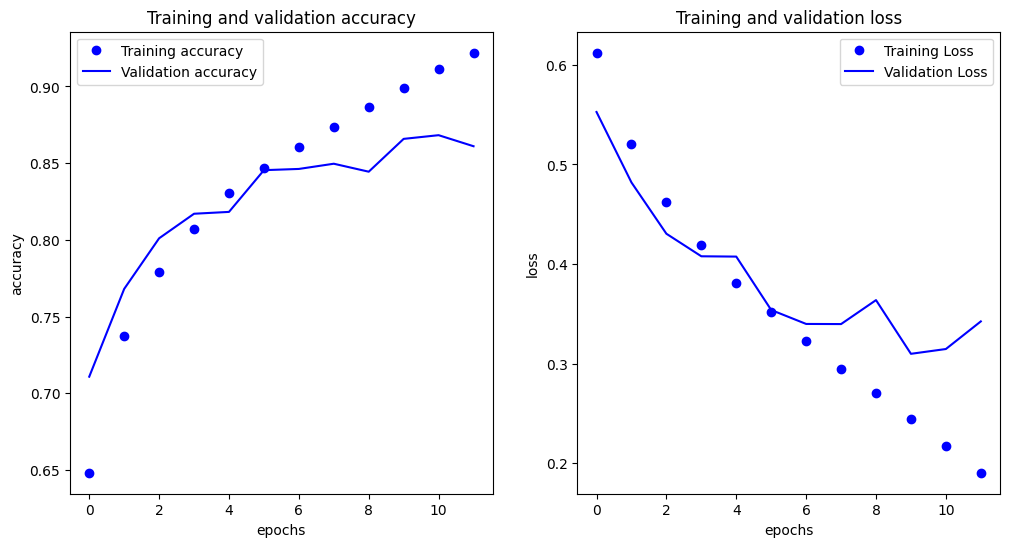

In [11]:
def plot_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()
    
    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    
    plt.show()

plot_loss_acc(history)

so far this was the traditional way to approach the Models , Now using Data Augmentation approach

In [12]:
FILL_MODE = 'nearest'

data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(150,150,3)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2 , fill_mode=FILL_MODE),
    tf.keras.layers.RandomTranslation(0.2 , 0.2 , fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
])

In [16]:
def img_augmentation(sample_img, model, num_aug):
    image_preview = []
    sample_image_pil = tf.keras.utils.array_to_img(sample_img)
    image_preview.append(sample_image_pil)

    for i in range(num_aug):
        sample_image_aug = model(tf.expand_dims(sample_img, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug, axis=0))
        image_preview.append(sample_image_aug_pil)

    fig, axes = plt.subplots(1, len(image_preview), figsize=(12, 12))
    
    if len(image_preview) == 1:
        axes = [axes]

    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()
        
        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')
    
    plt.show()


preview of the augmented images

In [17]:
sample_batch = list(train_dataset.take(1))[0][0]
print(f'images per batch : {len(sample_batch)}')

images per batch : 20


2025-07-21 11:07:15.757520: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


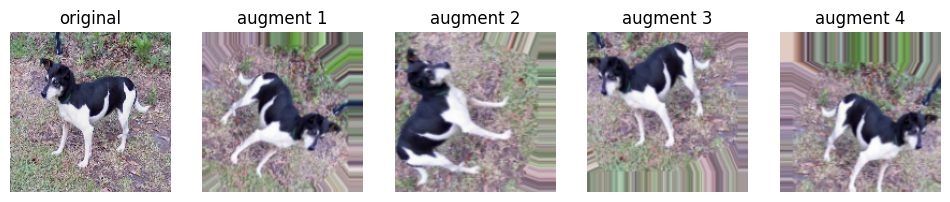

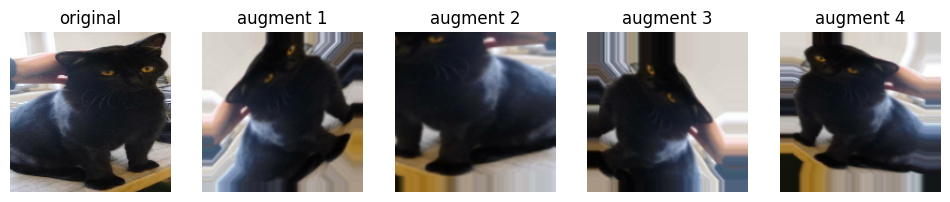

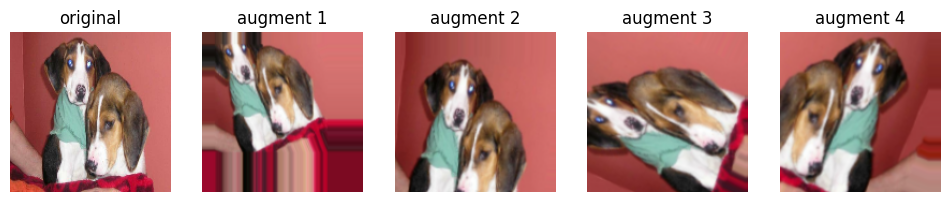

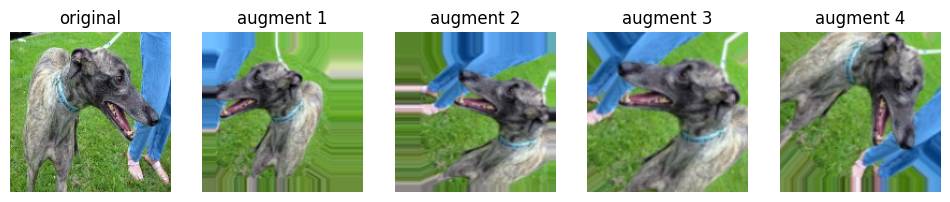

In [18]:
NUM_AUG = 4

img_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
img_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
img_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
img_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

In [19]:
model_without_aug = create_model()

model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model_without_aug
])

model_with_aug.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

In [20]:
history_with_aug = model_with_aug.fit(
      final_training_dataset,
      epochs=30,
      validation_data=final_validation_dataset,
      callbacks = [EarlyStopping()],
      verbose=2)

Epoch 1/30
1000/1000 - 16s - 16ms/step - accuracy: 0.5766 - loss: 0.6725 - val_accuracy: 0.6290 - val_loss: 0.6360
Epoch 2/30
1000/1000 - 14s - 14ms/step - accuracy: 0.6532 - loss: 0.6202 - val_accuracy: 0.6952 - val_loss: 0.5768
Epoch 3/30
1000/1000 - 14s - 14ms/step - accuracy: 0.6771 - loss: 0.5951 - val_accuracy: 0.7016 - val_loss: 0.5684
Epoch 4/30
1000/1000 - 14s - 14ms/step - accuracy: 0.6919 - loss: 0.5787 - val_accuracy: 0.7482 - val_loss: 0.5134
Epoch 5/30
1000/1000 - 14s - 14ms/step - accuracy: 0.7113 - loss: 0.5609 - val_accuracy: 0.7340 - val_loss: 0.5300
Epoch 6/30
1000/1000 - 14s - 14ms/step - accuracy: 0.7237 - loss: 0.5428 - val_accuracy: 0.7532 - val_loss: 0.4999
Epoch 7/30
1000/1000 - 14s - 14ms/step - accuracy: 0.7262 - loss: 0.5414 - val_accuracy: 0.7710 - val_loss: 0.4794
Epoch 8/30
1000/1000 - 14s - 14ms/step - accuracy: 0.7374 - loss: 0.5266 - val_accuracy: 0.7860 - val_loss: 0.4493
Epoch 9/30
1000/1000 - 14s - 14ms/step - accuracy: 0.7462 - loss: 0.5172 - val_a

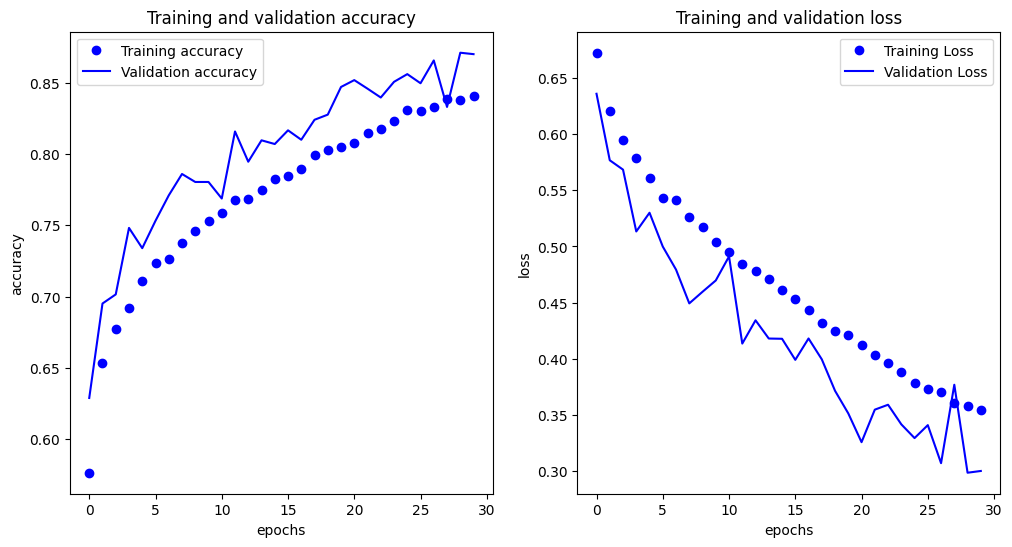

In [21]:
plot_loss_acc(history_with_aug)

the spike after the 25th epoch in val_loss and val_acc is a bit concerning else it is pretty good 